In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood
import random
from sklearn.preprocessing import StandardScaler

# Make plots inline
%matplotlib inline

In [2]:
random.seed(666)

# 1 Read Data

In [3]:
#read the data and create data frame
df = pd.read_csv('heart_rate_data.csv')
df['time'] = np.linspace(0, 900, len(df))
df.columns = ['Y','time']
print(df.shape)
df.head(3)

(1799, 2)


,Y,time
0,84.2697,0.000000
1,84.0619,0.500556
2,85.6542,1.001112


In [4]:
#normalize Y
Y = df['Y'].to_numpy().reshape(-1, 1)
transformer = StandardScaler().fit(Y)
df['Y'] = transformer.transform(Y)

In [5]:
train_size = 400 #at the head
test_size = 100 #in the middle
train_size2 = 400 #at the tail
split = train_size + test_size + train_size2

#get training set
train = df[0:train_size].append(df[train_size + test_size:split]) 
X_train_ = np.array(train['time'])
Y_train_ = np.array(train['Y'])

#get testing set
test = df[train_size-1:train_size+test_size+1]
X_test_ = np.array(test['time'])
Y_test_ = np.array(test['Y'])

# Below df are only used for poltting the data
# we add nan in between 2 parts of training data to avoid the straight line between twp training set in later plotting
df_train_two_side = df.copy(deep=True)
df_train_two_side['Y'][train_size:train_size+test_size] = np.nan
train_2_side = df_train_two_side[0:split]
X_train_with_nan_ = np.array(train_2_side['time'])
Y_train_with_nan_ = np.array(train_2_side['Y'])  

/var/folders/ts/xc6_h0kd5nv7gws_x4n04jwr0000gn/T/ipykernel_22437/2220403501.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = df[0:train_size].append(df[train_size + test_size:split])


In [6]:
#make data into tensor format
X_train = torch.tensor(X_train_)
Y_train = torch.tensor(Y_train_)

X_test = torch.tensor(X_test_)
Y_test = torch.tensor(Y_test_)

X_train_with_nan = torch.tensor(X_train_with_nan_)
Y_train_with_nan = torch.tensor(Y_train_with_nan_) 

# 2 Implement Model with GpyTorch

## Settings for Experiment

'Model 1.1.1: RBF'

'Model 1.1.2: RBF + Fixed Noise Likelihood'

'Model 1.2.1: RBF + SKI'

'Model 1.2.2: RBF + SKI + Fixed Noise Likelihood'

'Model 2.1.1: Periodic'

'Model 2.1.2: Periodic + Fixed Noise Likelihood'

'Model 2.2.1: Periodic + SKI'

'Model 2.2.2: Periodic + SKI + Fixed Noise Likelihood'

'Model 3.1.1: Periodic + RBF'

'Model 3.1.2: Periodic + RBF + Fixed Noise Likelihood'

'Model 3.2.1: Periodic + RBF + SKI'

'Model 3.2.2: Periodic + RBF + SKI + Fixed Noise Likelihood'

Deep Model-----------

In [7]:
#we have 3 * 2 * 2 = 12 experiment in our first set
model_name_list = [[['Model 1.1.1: RBF', 'Model 1.1.2: RBF + Fixed Noise Likelihood'], ['Model 1.2.1: RBF + SKI', 'Model 1.2.2: RBF + SKI + Fixed Noise Likelihood']],\
        [['Model 2.1.1: Periodic', 'Model 2.1.2: Periodic + Fixed Noise Likelihood'], ['Model 2.2.1: Periodic + SKI', 'Model 2.2.2: Periodic + SKI + Fixed Noise Likelihood']], \
        [['Model 3.1.1: Periodic + RBF', 'Model 3.1.2: Periodic + RBF + Fixed Noise Likelihood'], ['Model 3.2.1: Periodic + RBF + SKI', 'Model 3.2.2: Periodic + RBF + SKI + Fixed Noise Likelihood']]]

In [8]:
kernel_list = [gpytorch.kernels.RBFKernel(), gpytorch.kernels.PeriodicKernel(), gpytorch.kernels.RBFKernel() + gpytorch.kernels.PeriodicKernel()]

In [9]:
def plot_loss_in_training_process(experiment_index, train_losses_mll, test_losses_mse, test_losses_msll):
    #plot loss log
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle(model_name_list[experiment_index[0]][experiment_index[1]][experiment_index[2]] + ' Loss w.r.t Training Epoch')
    axs[0].plot(train_losses_mll, label = 'Training Loss MLL')
    axs[0].set_xlabel('Iterations')
    axs[0].set_ylabel('Loss (MLL)')
    axs[0].set_title('Training Error')
    axs[0].legend()

    axs[1].set_xlabel('Iterations')
    axs[1].set_ylabel('Loss (MSE)')
    axs[1].plot(test_losses_mse, label = 'Testing Loss MSE', c = 'orange')
    axs[1].set_title('testing error')
    axs[1].legend()

    axs[2].set_xlabel('Iterations')
    axs[2].set_ylabel('Loss (MSLL)')
    axs[2].plot(test_losses_msll, label = 'Testing Loss MSLL', c = 'purple')
    axs[2].set_title('Testing Error')
    axs[2].legend()

In [10]:
def plot_predicting_result(model, likelihood, experiment_index, X_train, X_train_with_nan, Y_train_with_nan, X_test, Y_test):
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        train_prediction = likelihood(model(X_train))
        train_mean = train_prediction.mean
        test_prediction = likelihood(model(X_test))
        test_mean = test_prediction.mean
        train_lower, train_upper = train_prediction.confidence_region()
        test_lower, test_upper = test_prediction.confidence_region()

    #add nan in the middle of testing prediction, use for later plotting
    y_pred_train_with_nan = d = np.concatenate((np.array(train_mean[0:train_size])\
        , np.array([np.nan for i in range(test_size)]), np.array(train_mean[train_size:]))) 
    y_pred_test = np.array(test_mean)


    plt.figure(figsize=(10,6))
    plt.plot(X_train_with_nan, Y_train_with_nan, 'y.', markersize=10, label='training data') #plot training data
    plt.plot(X_train_with_nan, y_pred_train_with_nan, 'g-', label='Training Set Prediction') # plot training prediction
    plt.plot(X_test, Y_test, 'r.', markersize=10, label='testing data') #plot testing data
    plt.plot(X_test, y_pred_test, 'b-', label='Testing Set Prediction') #plot testing prediction
    plt.fill_between(X_test, test_lower, test_upper, alpha=0.5, label = 'Testing CI') #add CI

    plt.title(model_name_list[experiment_index[0]][experiment_index[1]][experiment_index[2]] +  ' Interpolation Result Analysis')
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.legend(loc='upper left')
    plt.show()

In [11]:
def training(model, likelihood, optimizer, mll, training_iterations = 300):
    start_time = time.time()
    train_losses_mll = []
    test_losses_mse = []
    test_losses_msll = []
    time_list = []

    for epoch in range(training_iterations):
        #get train loss for this iter
        model.train()
        likelihood.train()
        optimizer.zero_grad()
        train_predition = model(X_train)
        train_loss = -mll(train_predition, Y_train)        
        train_losses_mll.append(train_loss)
        time_list.append(time.time() - start_time)
        train_loss.backward()
        optimizer.step()

        #get test loss for this iter
        model.eval()
        with torch.no_grad():
            trained_pred_dist = likelihood(model(X_test))
            predictive_mean = trained_pred_dist.mean
            lower, upper = trained_pred_dist.confidence_region()
            #here we use mse instead of marginal log likelihood because 
            #ow error occur: Matrix not positive definite after repeatedly adding jitter up to 1.0e-06
            test_msll = gpytorch.metrics.mean_standardized_log_loss(trained_pred_dist, Y_test)
            test_mse = np.mean(np.square(np.array(predictive_mean - Y_test)))
            test_losses_mse.append(test_mse)
            test_losses_msll.append(test_msll)
    
    end_time = time.time()
    train_losses_mll = [float(i) for i in train_losses_mll]
    test_losses_mse = [float(i) for i in test_losses_mse]
    test_losses_msll = [float(i) for i in test_losses_msll]

    print('tesing MSE after', training_iterations, 'epochs:', test_losses_mse[-1])
    print('tesing MSLL after', training_iterations, 'epochs:', test_losses_msll[-1])
    print('training duration for', training_iterations, 'epochs:', end_time - start_time)

    return time_list, train_losses_mll, test_losses_mse, test_losses_msll, end_time - start_time
    

In [12]:
def GP_experiment(experiment_index):
    current_experiment_index = experiment_index
    #define the model
    class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood, experiment_index):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            
            grid_size = gpytorch.utils.grid.choose_grid_size(train_x,1.0) # SKI requires a grid size hyperparameter.
            #we are going to warpping below kernel inside the interpolation kernel
            self.base_kernel = gpytorch.kernels.RBFKernel()

            #Exp-Sine-Squared kernel (aka periodic kernel)

            self.mean_module = gpytorch.means.ConstantMean()
            
            if experiment_index[1] == 0: #without SKI
                self.covar_module = gpytorch.kernels.ScaleKernel(kernel_list[experiment_index[0]])
            else: #with SKI
                self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.GridInterpolationKernel(kernel_list[experiment_index[0]], grid_size=grid_size, num_dims=1))

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    #training
    likelihood = gpytorch.likelihoods.GaussianLikelihood() if current_experiment_index[2] == 0 else FixedNoiseGaussianLikelihood(torch.ones(len(X_train))* 0.01, learn_additional_noise=True)
    model = GPRegressionModel(X_train, Y_train, likelihood, current_experiment_index)
    
    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()
    
    return model, likelihood

### Model 1.1.1: RBF

tesing MSE after 300 epochs: 0.7605797399139094
tesing MSLL after 300 epochs: 0.8902233879284482
training duration for 300 epochs: 24.004711151123047


/Users/zhanghanyuan/opt/anaconda3/envs/timeseries/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


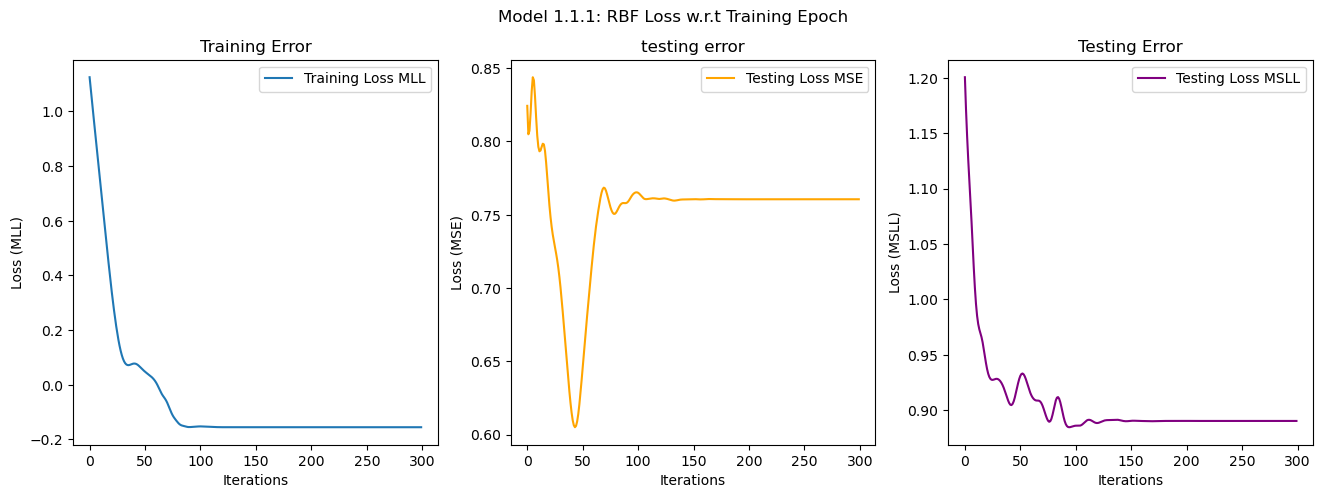

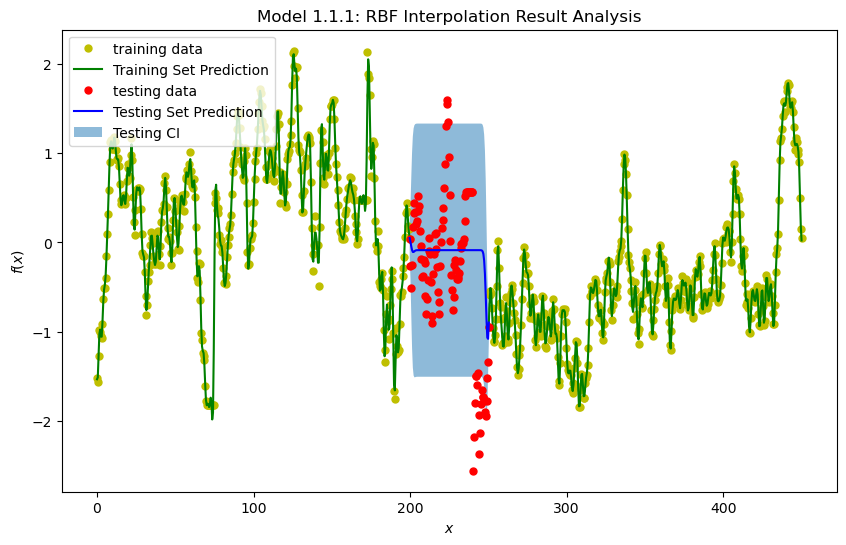

In [13]:
current_experiment_index = [0, 0, 0]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result(model, likelihood, current_experiment_index, X_train, X_train_with_nan, Y_train_with_nan, X_test, Y_test)

### Model 1.1.2: RBF + Fixed Noise Likelihood

tesing MSE after 300 epochs: 0.7554495013067617
tesing MSLL after 300 epochs: 0.8903976123227617
training duration for 300 epochs: 24.864852905273438


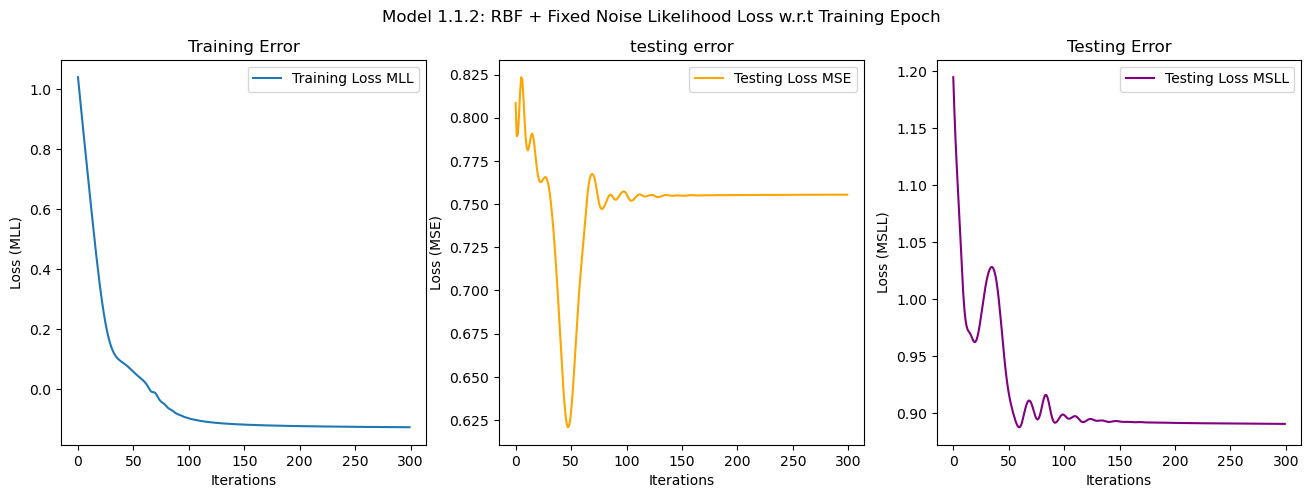

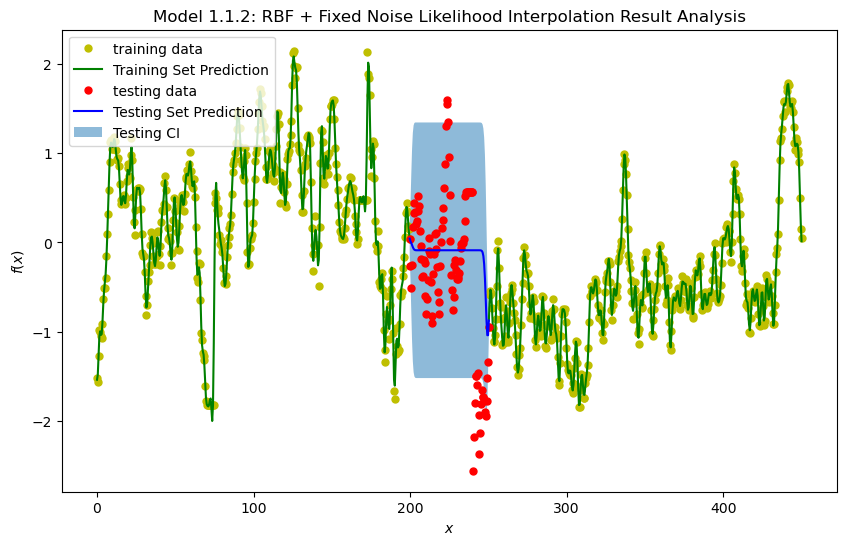

In [14]:
current_experiment_index = [0, 0, 1]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)
time_list112, train_losses_mll112 = time_list, train_losses_mll

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result(model, likelihood, current_experiment_index, X_train, X_train_with_nan, Y_train_with_nan, X_test, Y_test)

### Model 1.2.1: RBF + SKI

tesing MSE after 300 epochs: 0.7620327416437283
tesing MSLL after 300 epochs: 0.893659956398927
training duration for 300 epochs: 76.53372287750244


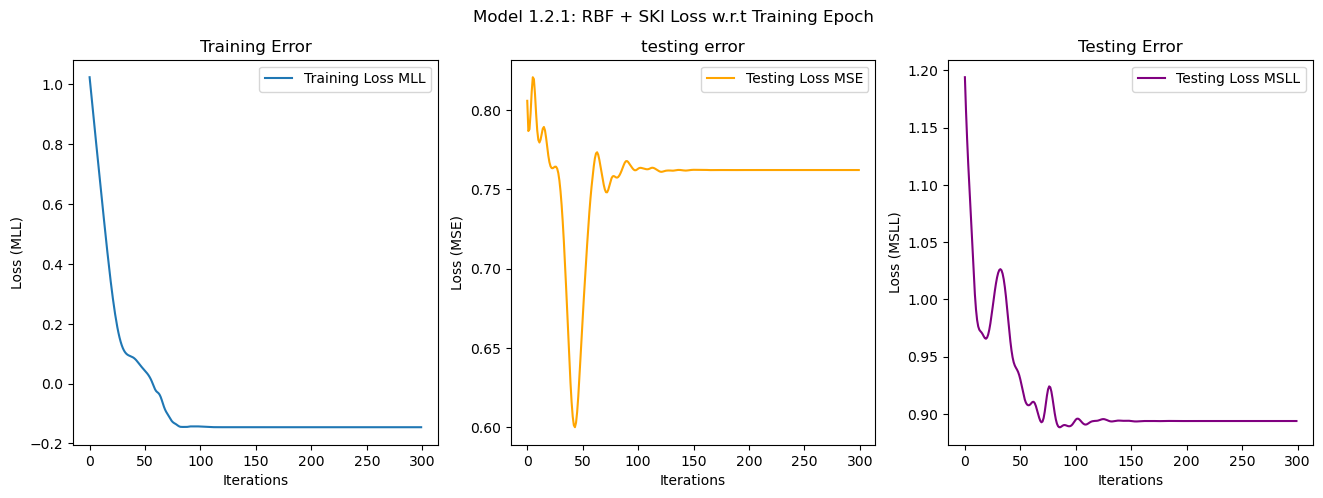

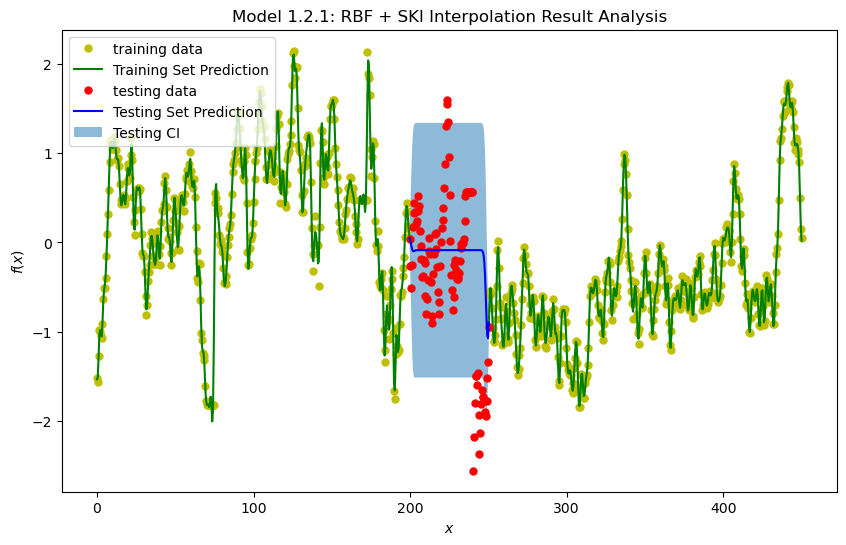

In [15]:
current_experiment_index = [0, 1, 0]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result(model, likelihood, current_experiment_index, X_train, X_train_with_nan, Y_train_with_nan, X_test, Y_test)

### Model 1.2.2: RBF + SKI + Fixed Noise Likelihood

tesing MSE after 300 epochs: 0.7569272778968835
tesing MSLL after 300 epochs: 0.8919945173925684
training duration for 300 epochs: 70.2941381931305


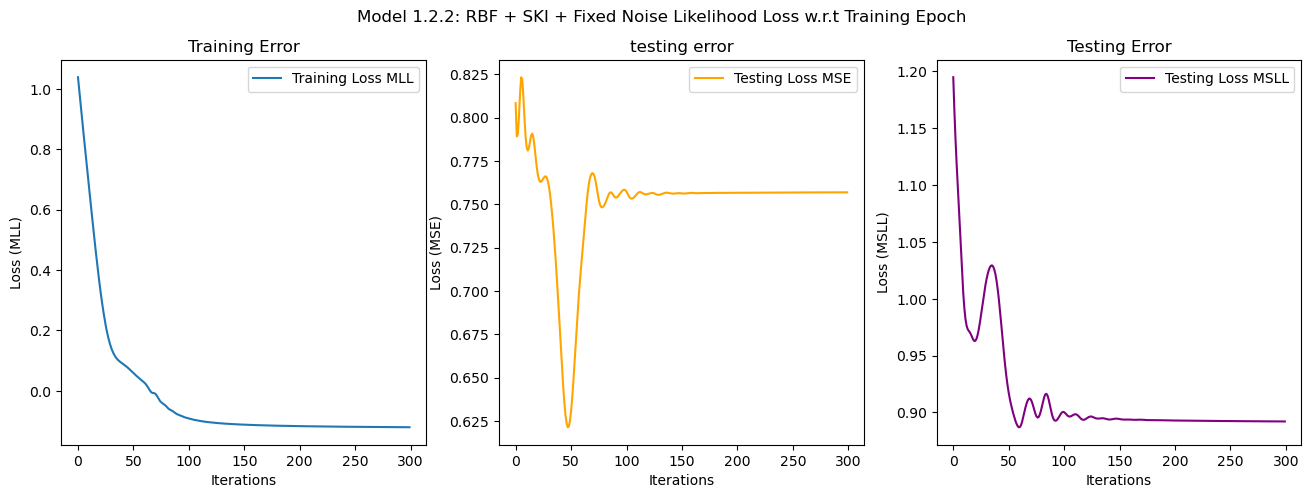

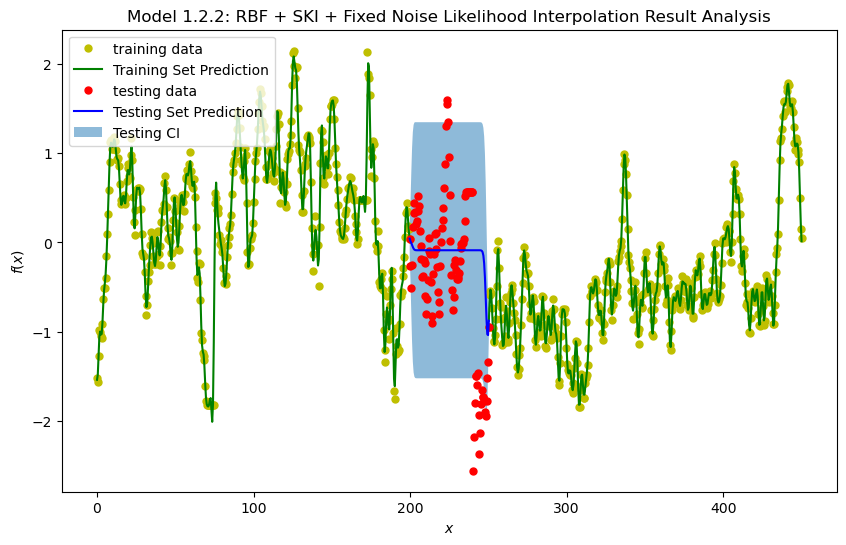

In [16]:
current_experiment_index = [0, 1, 1]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)
time_list122, train_losses_mll122 = time_list, train_losses_mll

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result(model, likelihood, current_experiment_index, X_train, X_train_with_nan, Y_train_with_nan, X_test, Y_test)

### Model 2.1.1: Periodic

tesing MSE after 300 epochs: 0.8531741589650977
tesing MSLL after 300 epochs: 1.0516957997079805
training duration for 300 epochs: 37.68322515487671


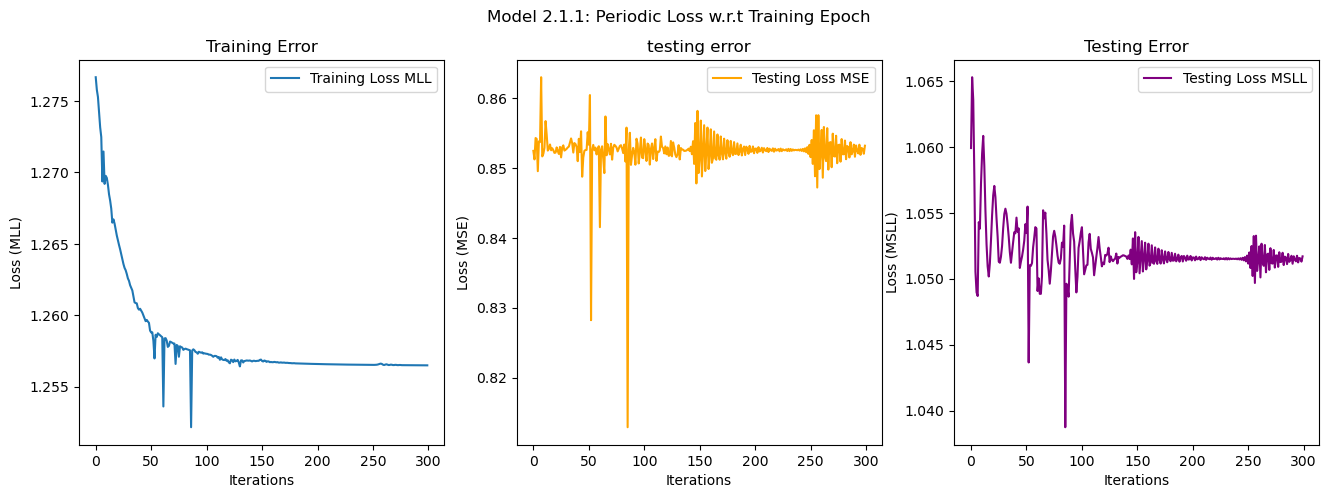

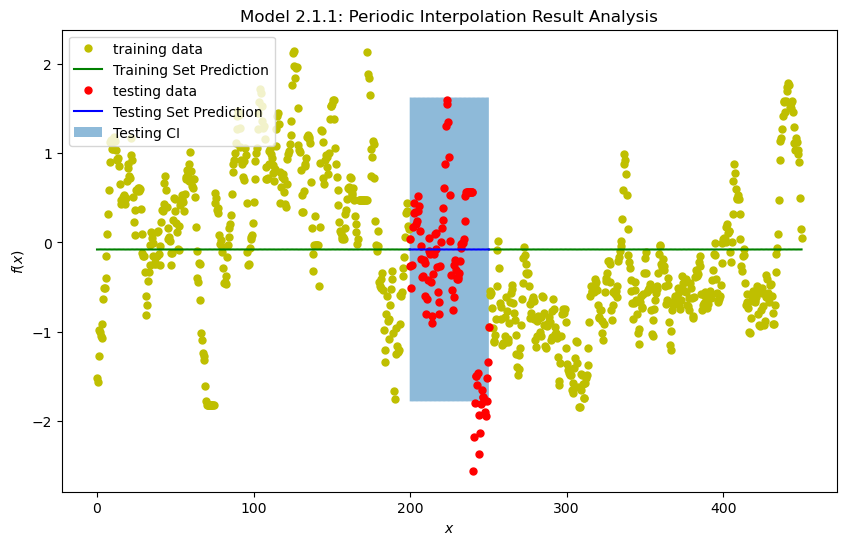

In [17]:
current_experiment_index = [1, 0, 0]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result(model, likelihood, current_experiment_index, X_train, X_train_with_nan, Y_train_with_nan, X_test, Y_test)

### Model 2.1.2: Periodic + Fixed Noise Likelihood

tesing MSE after 300 epochs: 0.8524165242766376
tesing MSLL after 300 epochs: 1.0485770080415022
training duration for 300 epochs: 32.16677904129028


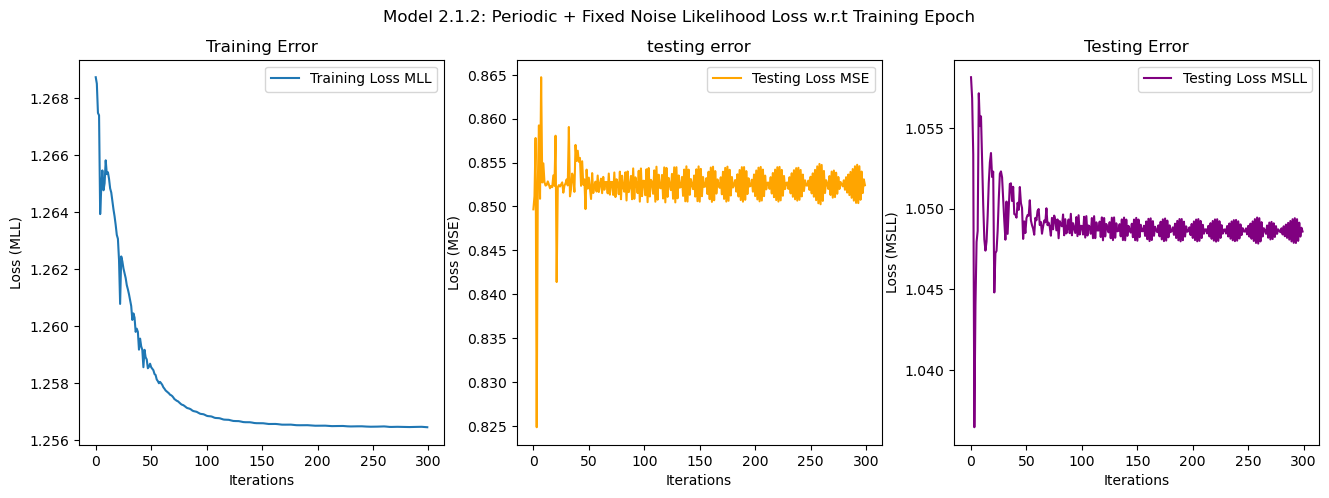

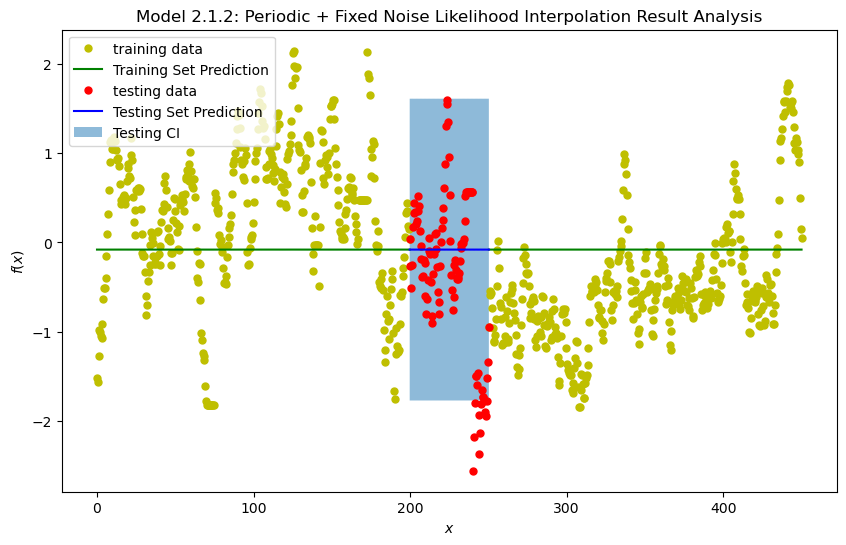

In [18]:
current_experiment_index = [1, 0, 1]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)
time_list212, train_losses_mll212 = time_list, train_losses_mll

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result(model, likelihood, current_experiment_index, X_train, X_train_with_nan, Y_train_with_nan, X_test, Y_test)

### Model 2.2.1: Periodic + SKI

tesing MSE after 300 epochs: 0.8514321420769808
tesing MSLL after 300 epochs: 1.0511181329922064
training duration for 300 epochs: 70.88582301139832


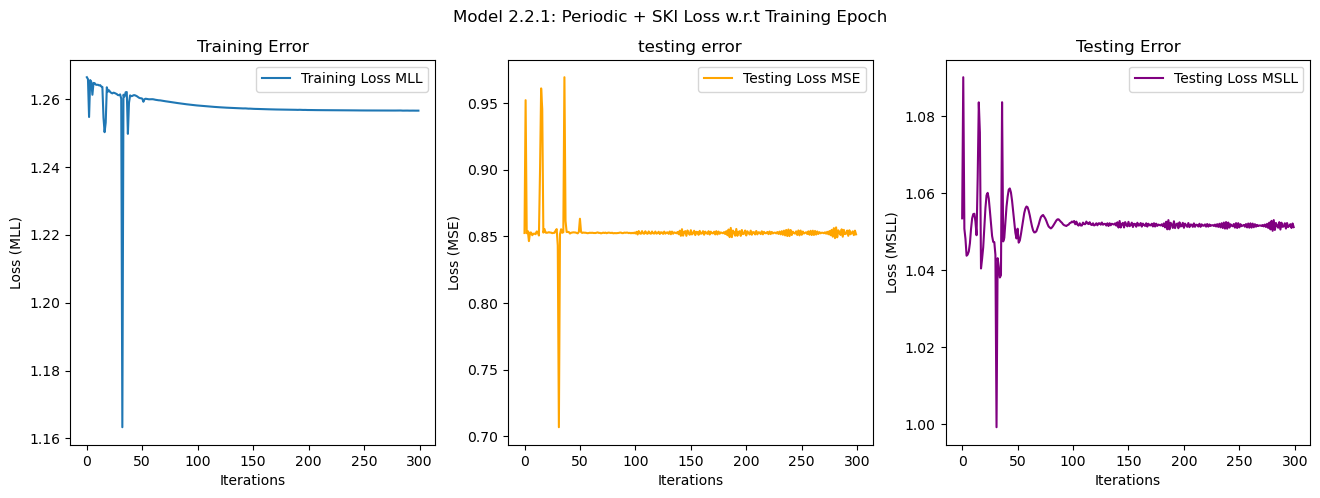

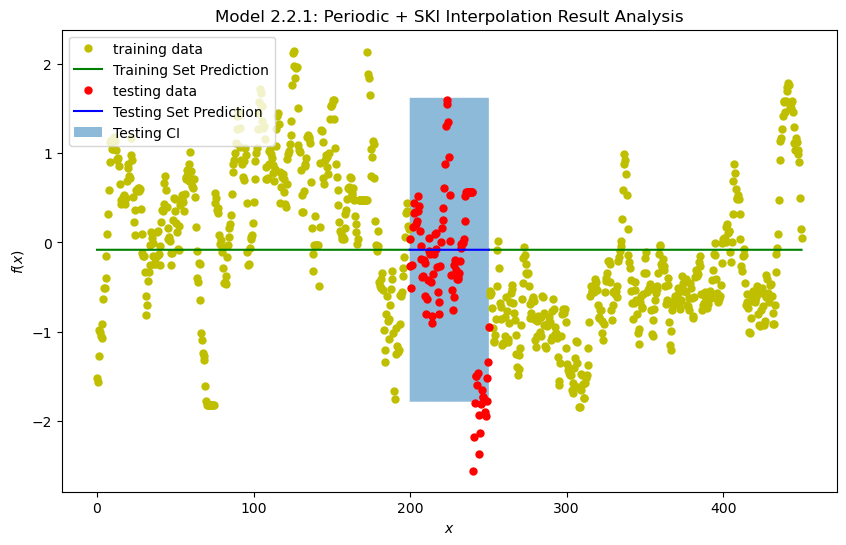

In [19]:
current_experiment_index = [1, 1, 0]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result(model, likelihood, current_experiment_index, X_train, X_train_with_nan, Y_train_with_nan, X_test, Y_test)

### Model 2.2.2: Periodic + SKI + Fixed Noise Likelihood

tesing MSE after 300 epochs: 0.851625058492345
tesing MSLL after 300 epochs: 1.0484692445646473
training duration for 300 epochs: 69.2456042766571


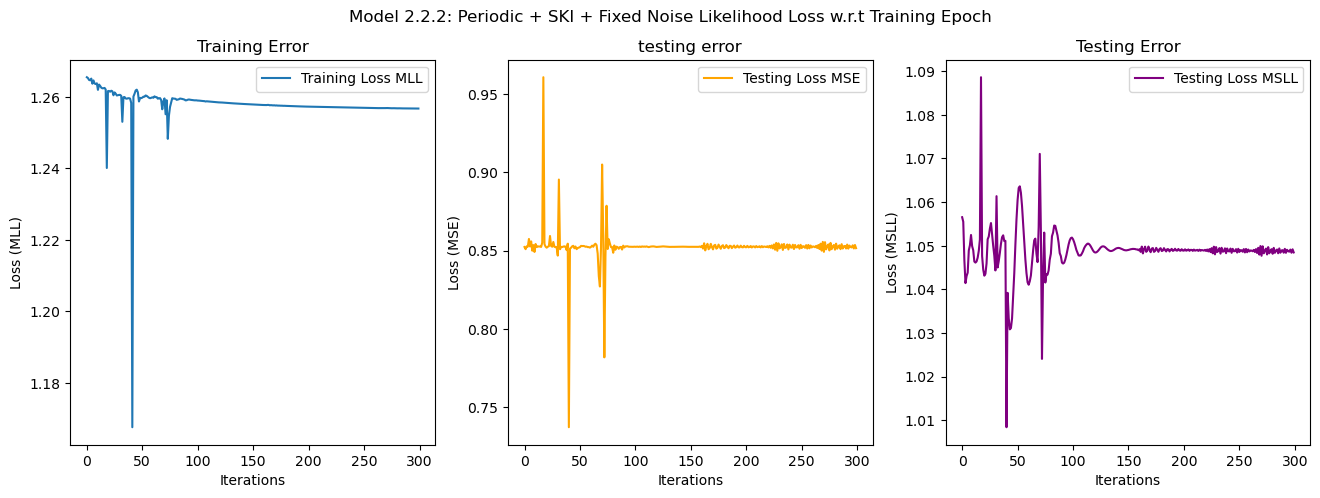

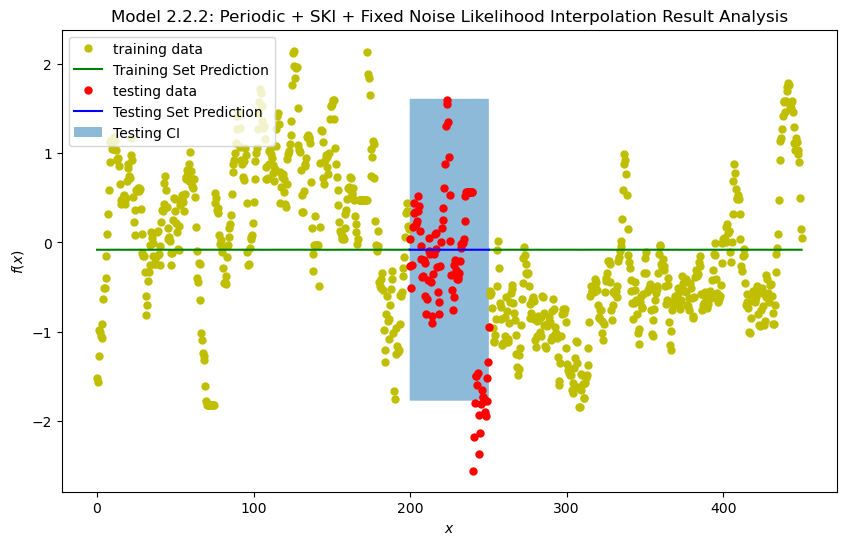

In [20]:
current_experiment_index = [1, 1, 1]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)
time_list222, train_losses_mll222 = time_list, train_losses_mll

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result(model, likelihood, current_experiment_index, X_train, X_train_with_nan, Y_train_with_nan, X_test, Y_test)

### Model 3.1.1: Periodic + RBF

tesing MSE after 300 epochs: 0.7622386475185061
tesing MSLL after 300 epochs: 0.8924940362245776
training duration for 300 epochs: 36.527512073516846


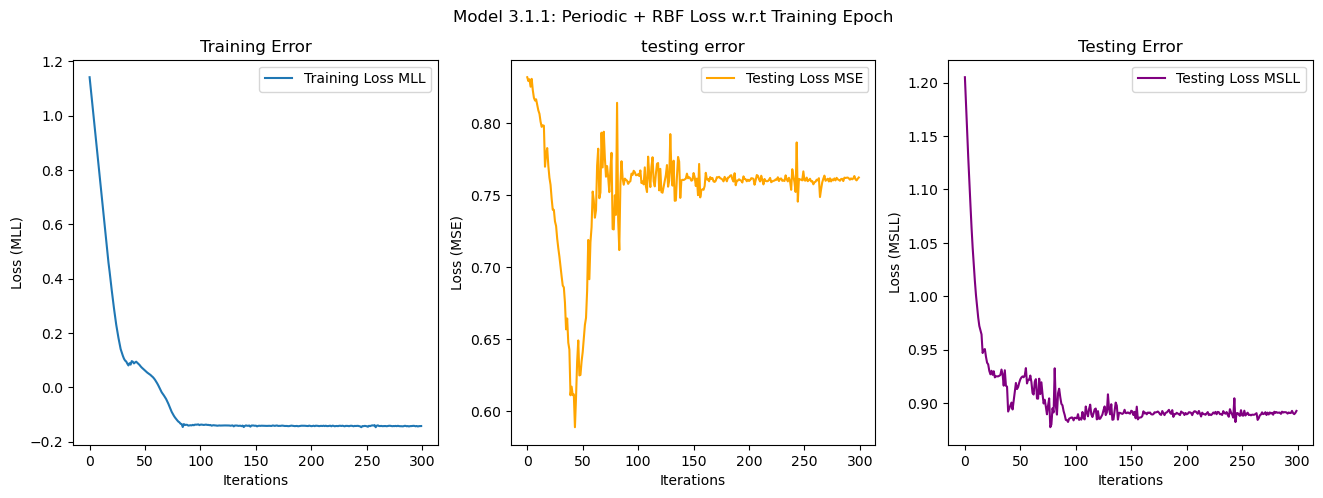

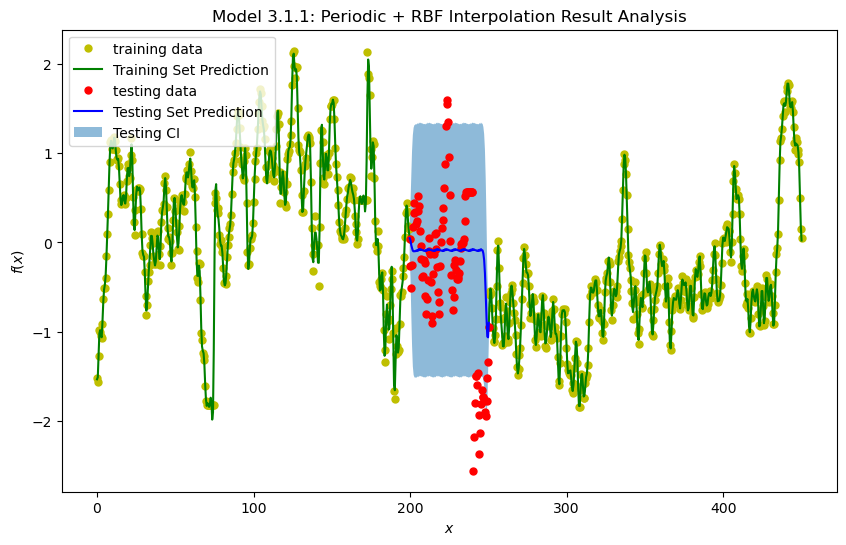

In [21]:
current_experiment_index = [2, 0, 0]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result(model, likelihood, current_experiment_index, X_train, X_train_with_nan, Y_train_with_nan, X_test, Y_test)

### Model 3.1.2: Periodic + RBF + Fixed Noise Likelihood

tesing MSE after 300 epochs: 0.7574182279600297
tesing MSLL after 300 epochs: 0.8909443932975879
training duration for 300 epochs: 36.6235728263855


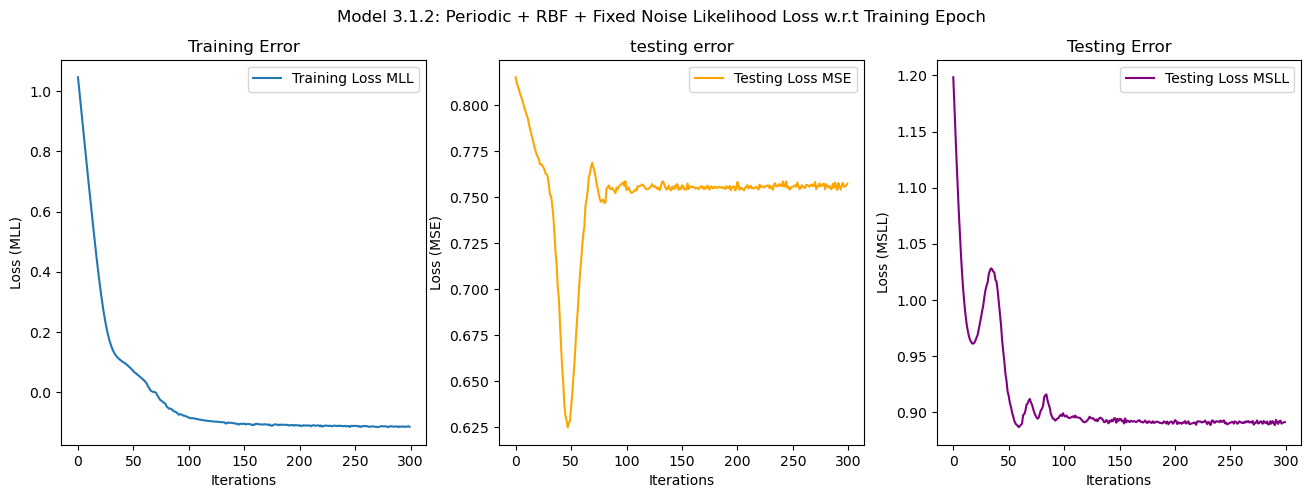

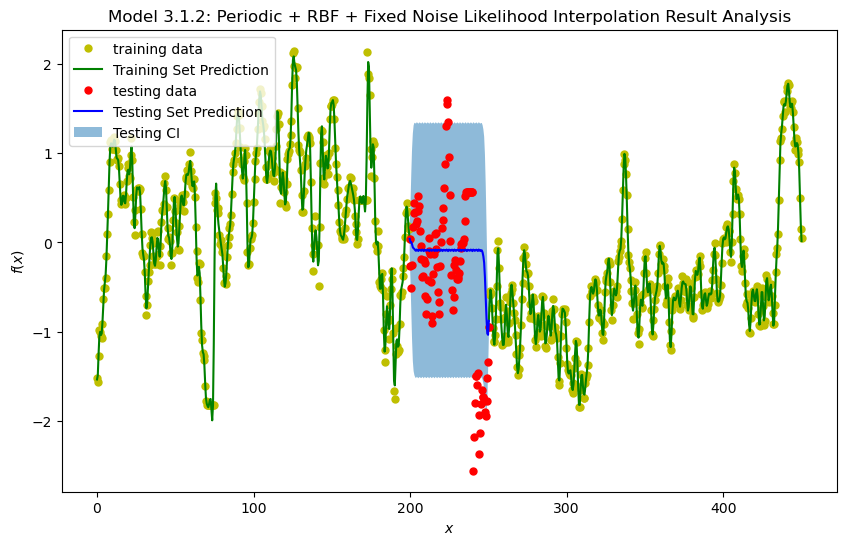

In [22]:
current_experiment_index = [2, 0, 1]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)
time_list312, train_losses_mll312 = time_list, train_losses_mll

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result(model, likelihood, current_experiment_index, X_train, X_train_with_nan, Y_train_with_nan, X_test, Y_test)

### Model 3.2.1: Periodic + RBF + SKI

tesing MSE after 300 epochs: 0.765445729259147
tesing MSLL after 300 epochs: 0.8950492027534547
training duration for 300 epochs: 72.03487420082092


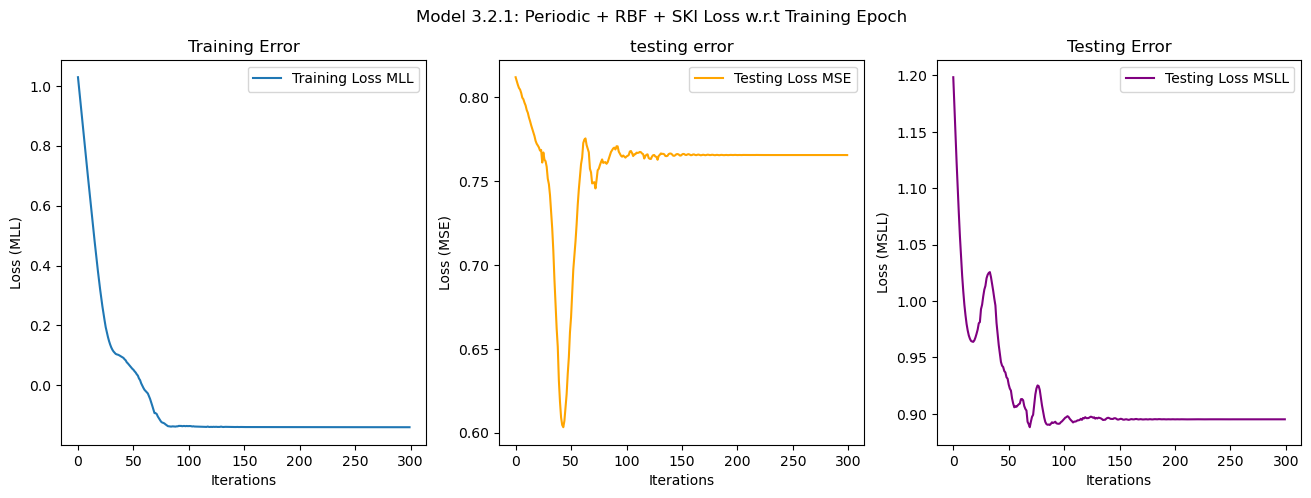

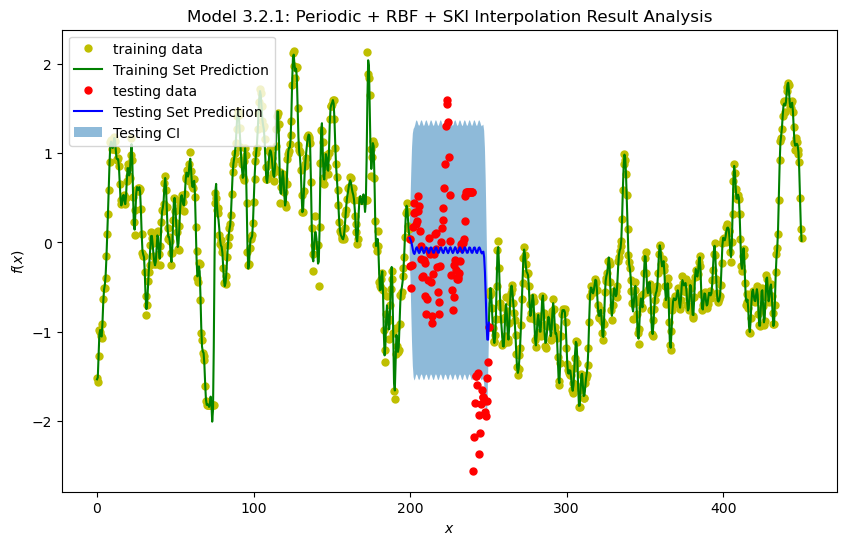

In [23]:
current_experiment_index = [2, 1, 0]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result(model, likelihood, current_experiment_index, X_train, X_train_with_nan, Y_train_with_nan, X_test, Y_test)

### Model 3.2.2: Periodic + RBF + SKI + Fixed Noise Likelihood

tesing MSE after 300 epochs: 0.7577025700183837
tesing MSLL after 300 epochs: 0.8922076020137388
training duration for 300 epochs: 80.77031207084656


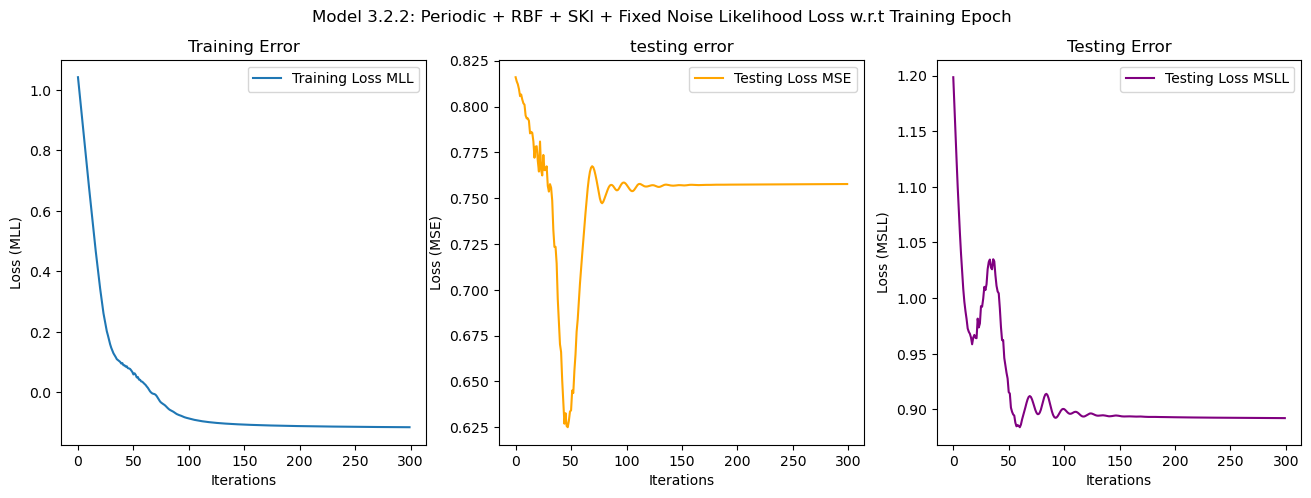

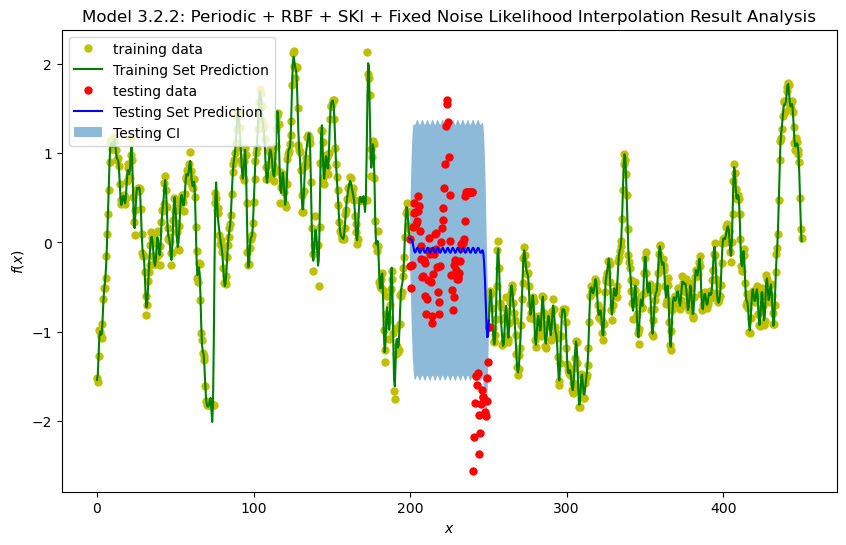

In [24]:
current_experiment_index = [2, 1, 1]

#get our current model and likelihood
model, likelihood = GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 300)
time_list322, train_losses_mll322 = time_list, train_losses_mll

#plot loss log
plot_loss_in_training_process(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result(model, likelihood, current_experiment_index, X_train, X_train_with_nan, Y_train_with_nan, X_test, Y_test)

## Speed Analysis

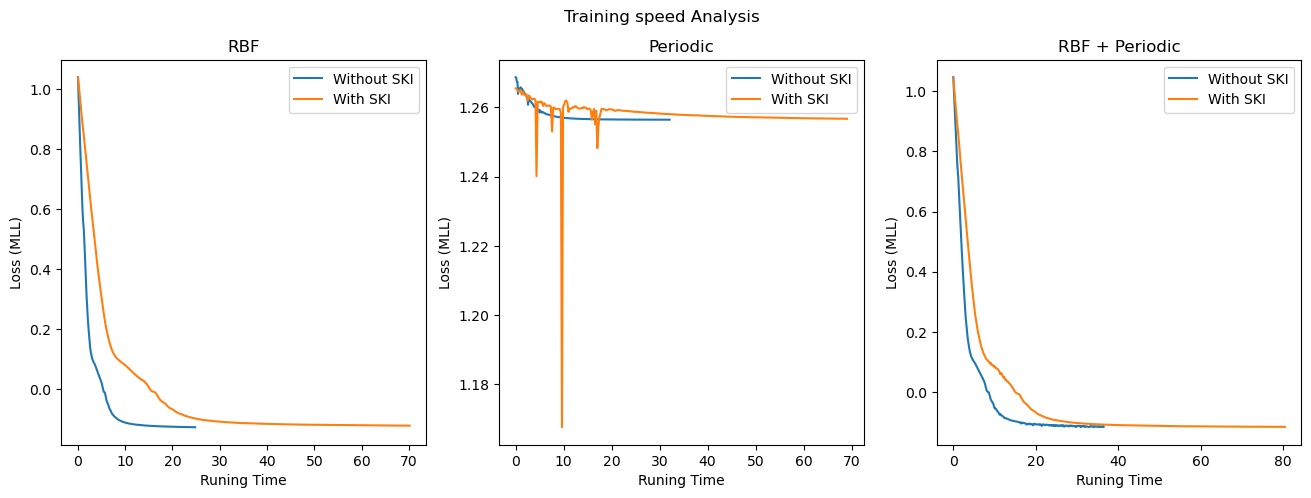

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Training speed Analysis')

axs[0].plot(time_list112, train_losses_mll112, label = 'Without SKI')
axs[0].plot(time_list122, train_losses_mll122, label = 'With SKI')
axs[0].set_xlabel('Runing Time')
axs[0].set_ylabel('Loss (MLL)')
axs[0].set_title('RBF')
axs[0].legend()

axs[1].set_xlabel('Runing Time')
axs[1].set_ylabel('Loss (MLL)')
axs[1].plot(time_list212, train_losses_mll212, label = 'Without SKI')
axs[1].plot(time_list222, train_losses_mll222, label = 'With SKI')
axs[1].set_title('Periodic')
axs[1].legend()

axs[2].set_xlabel('Runing Time')
axs[2].set_ylabel('Loss (MLL)')
axs[2].plot(time_list312, train_losses_mll312, label = 'Without SKI')
axs[2].plot(time_list322, train_losses_mll322, label = 'With SKI')
axs[2].set_title('RBF + Periodic')
axs[2].legend()

## Deep Model

### Settings

In [12]:
# we modify the data format (o.w some bug occurs in the training process)
X_train_deep = np.array(train['time']).reshape(-1,1)
X_train_deep = torch.tensor(X_train_deep).float()
Y_train_deep = np.array(train['Y']).reshape(-1,1)
Y_train_deep = torch.tensor(Y_train_deep).float().flatten()
X_test_deep = np.array(test['time']).reshape(-1,1)
X_test_deep = torch.tensor(X_test_deep).float().flatten()
Y_test_deep = np.array(test['Y']).reshape(-1,1)
Y_test_deep = torch.tensor(Y_test_deep).float().flatten()

In [13]:
class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self, input_dim):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(input_dim, 80))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(80, 60))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(60, 50))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(50, 2))

In [14]:
def deep_training(model, likelihood, optimizer, mll, training_iterations = 400):
    start_time = time.time()
    train_losses_mll = []
    test_losses_mse = []
    test_losses_msll = []
    for epoch in range(training_iterations):
        #get train loss for this iter
        model.train()
        likelihood.train()
        optimizer.zero_grad()
        train_predition = model(X_train_deep)
        train_loss = -mll(train_predition, Y_train_deep)
        train_losses_mll.append(train_loss)
        train_loss.backward()
        optimizer.step()

        #get test loss for this iter
        model.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            trained_pred_dist = likelihood(model(X_test_deep))
            predictive_mean = trained_pred_dist.mean
            lower, upper = trained_pred_dist.confidence_region()
            #here we use mse instead of marginal log likelihood because 
            #ow error occur: Matrix not positive definite after repeatedly adding jitter up to 1.0e-06
            test_mse = np.mean(np.square(np.array(predictive_mean - Y_test)))
            test_losses_mse.append(test_mse)
            test_msll = gpytorch.metrics.mean_standardized_log_loss(trained_pred_dist, Y_test_deep)
            test_losses_msll.append(test_msll)

    end_time = time.time()  

    train_losses_mll = [float(i) for i in train_losses_mll]
    test_losses_mse = [float(i) for i in test_losses_mse]
    test_losses_msll = [float(i) for i in test_losses_msll]

    print('tesing MSE after', training_iterations, 'epochs:', test_losses_mse[-1])
    print('tesing MSLL after', training_iterations, 'epochs:', test_losses_msll[-1])
    print('training duration for', training_iterations, 'epochs:', end_time - start_time)

    return train_losses_mll, test_losses_mse, test_losses_msll, end_time - start_time

In [15]:
def plot_predicting_result_deep(model, likelihood, experiment_index, X_train, X_train_with_nan, Y_train_with_nan, X_test, Y_test):
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        train_prediction = likelihood(model(X_train_deep))
        train_mean = train_prediction.mean
        test_prediction = likelihood(model(X_test_deep))
        test_mean = test_prediction.mean
        train_lower, train_upper = train_prediction.confidence_region()
        test_lower, test_upper = test_prediction.confidence_region()

    #add nan in the middle of testing prediction, use for later plotting
        y_pred_train_with_nan = d = np.concatenate((np.array(train_mean[0:train_size])\
        , np.array([np.nan for i in range(test_size)]), np.array(train_mean[train_size:]))) 
        y_pred_test = np.array(test_mean)
        plt.figure(figsize=(8,5))
        plt.plot(X_train_with_nan, Y_train_with_nan, 'y.', markersize=10, label='training data') #plot training data
        plt.plot(X_train_with_nan, y_pred_train_with_nan, 'g-', label='Training Set Prediction') # plot training prediction
        plt.plot(X_test, Y_test, 'r.', markersize=10, label='testing data') #plot testing data
        plt.plot(X_test, y_pred_test, 'b-', label='Testing Set Prediction') #plot testing prediction
        plt.fill_between(X_test, test_lower, test_upper, alpha=0.5, label = 'Testing CI') #add CI

        plt.title('Deep' + model_name_list[experiment_index[0]][experiment_index[1]][experiment_index[2]] + ' Predicting Result Analysis')
        plt.xlabel('$x$')
        plt.ylabel('$f(x)$')
        plt.legend(loc='upper left')
        plt.show()

In [16]:
def plot_loss_in_training_process_deep(experiment_index, train_losses_mll, test_losses_mse, test_losses_msll):
    #plot loss log
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle('Deep' + model_name_list[experiment_index[0]][experiment_index[1]][experiment_index[2]] + ' Loss w.r.t Training Epoch')
    axs[0].plot(train_losses_mll, label = 'Training Loss MLL')
    axs[0].set_xlabel('Iterations')
    axs[0].set_ylabel('Loss (MLL)')
    axs[0].set_title('Training Error')
    axs[0].legend()

    axs[1].set_xlabel('Iterations')
    axs[1].set_ylabel('Loss (MSE)')
    axs[1].plot(test_losses_mse, label = 'Testing Loss MSE', c = 'orange')
    axs[1].set_title('testing error')
    axs[1].legend()

    axs[2].set_xlabel('Iterations')
    axs[2].set_ylabel('Loss (MSLL)')
    axs[2].plot(test_losses_msll, label = 'Testing Loss MSLL', c = 'purple')
    axs[2].set_title('Testing Error')
    axs[2].legend()

In [17]:
def Deep_GP_experiment(experiment_index):
    class GPRegressionModel_Deep(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood, experiment_index):
            super(GPRegressionModel_Deep, self).__init__(train_x, train_y, likelihood)
            
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = self.covar_module = gpytorch.kernels.ScaleKernel(kernel_list[experiment_index[0]])
            self.feature_extractor = LargeFeatureExtractor(input_dim=train_x.size(-1))

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            # We're also scaling the features so that they're nice values
            projected_x = self.feature_extractor(x)
            projected_x = projected_x - projected_x.min(0)[0]
            projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1

            # The rest of this looks like what we've seen
            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    #training
    likelihood = gpytorch.likelihoods.GaussianLikelihood() if current_experiment_index[2] == 0 else FixedNoiseGaussianLikelihood(torch.ones(len(X_train_deep))* 0.01, learn_additional_noise=True)
    model = GPRegressionModel_Deep(X_train_deep, Y_train_deep, likelihood, current_experiment_index)
    
    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()
    
    return model, likelihood

### Model 1.1.2.2: Deep Model (RBF + No Interpolation + FixedNoiseLikelyhood + Deep) 

/Users/zhanghanyuan/opt/anaconda3/envs/timeseries/lib/python3.10/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:270: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


tesing MSE after 300 epochs: 5706.590077532706
tesing MSLL after 300 epochs: 255.4528045654297
training duration for 300 epochs: 6.45256495475769


/Users/zhanghanyuan/opt/anaconda3/envs/timeseries/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


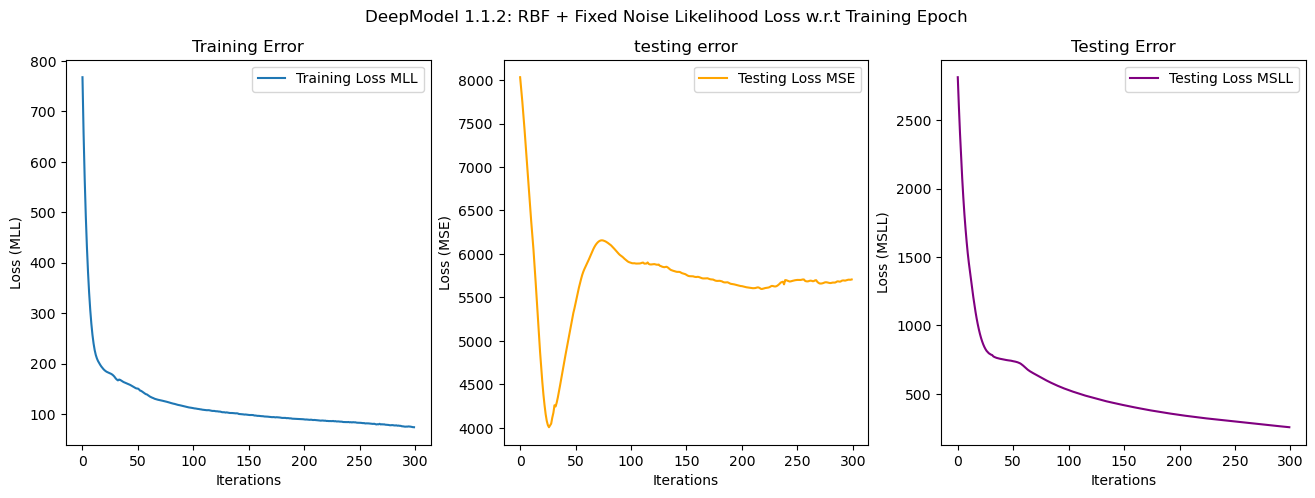

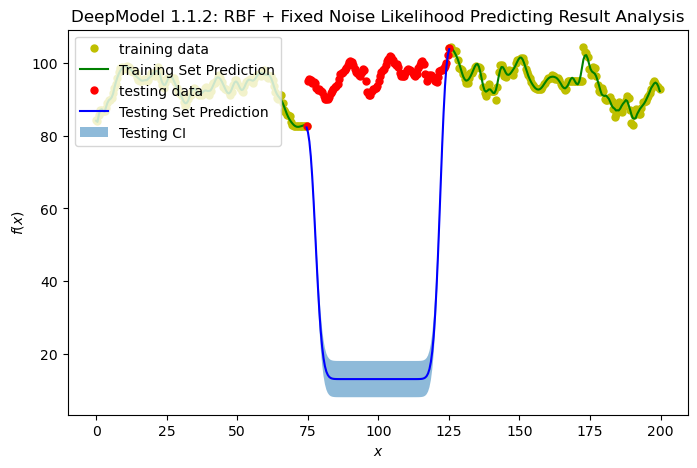

In [24]:
current_experiment_index = [0, 0, 1, 1]

#get our current model and likelihood
model, likelihood = Deep_GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  deep_training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 200)

#plot loss log
plot_loss_in_training_process_deep(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result_deep(model, likelihood, current_experiment_index, X_train_deep, X_train_with_nan, Y_train_with_nan, X_test, Y_test)

### Model 2.1.2.2: Deep Model (Periodic + No Interpolation + FixedNoiseLikelyhood + Deep) 

tesing MSE after 200 epochs: 45.11444949337657
tesing MSLL after 200 epochs: 292.6842346191406
training duration for 200 epochs: 13.015106916427612


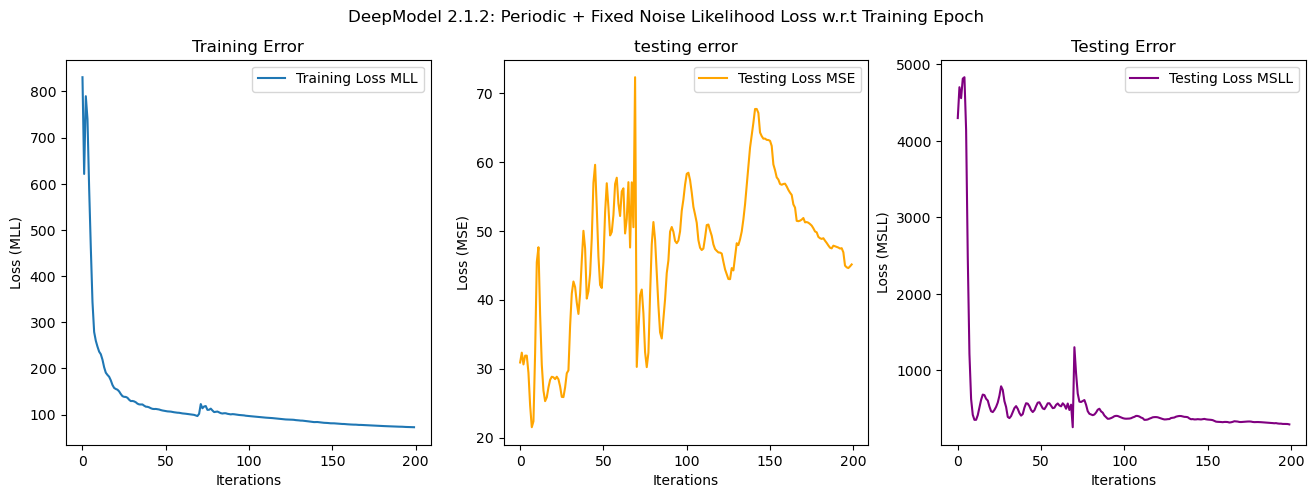

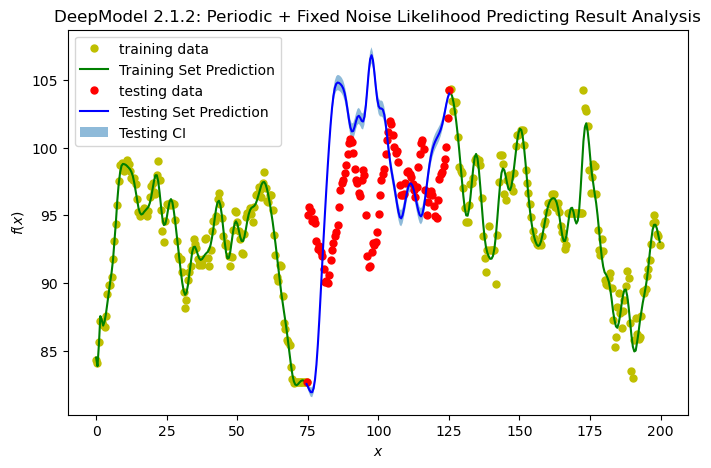

In [23]:
current_experiment_index = [1, 0, 1, 1]

#get our current model and likelihood
model, likelihood = Deep_GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  deep_training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 200)

#plot loss log
plot_loss_in_training_process_deep(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result_deep(model, likelihood, current_experiment_index, X_train_deep, X_train_with_nan, Y_train_with_nan, X_test, Y_test)

### Model 3.1.2.2: Deep Model (Periodic + RBF + No Interpolation + FixedNoiseLikelyhood + Deep) 

tesing MSE after 200 epochs: 10.16952757962413
tesing MSLL after 200 epochs: 2.274794578552246
training duration for 200 epochs: 13.855259895324707


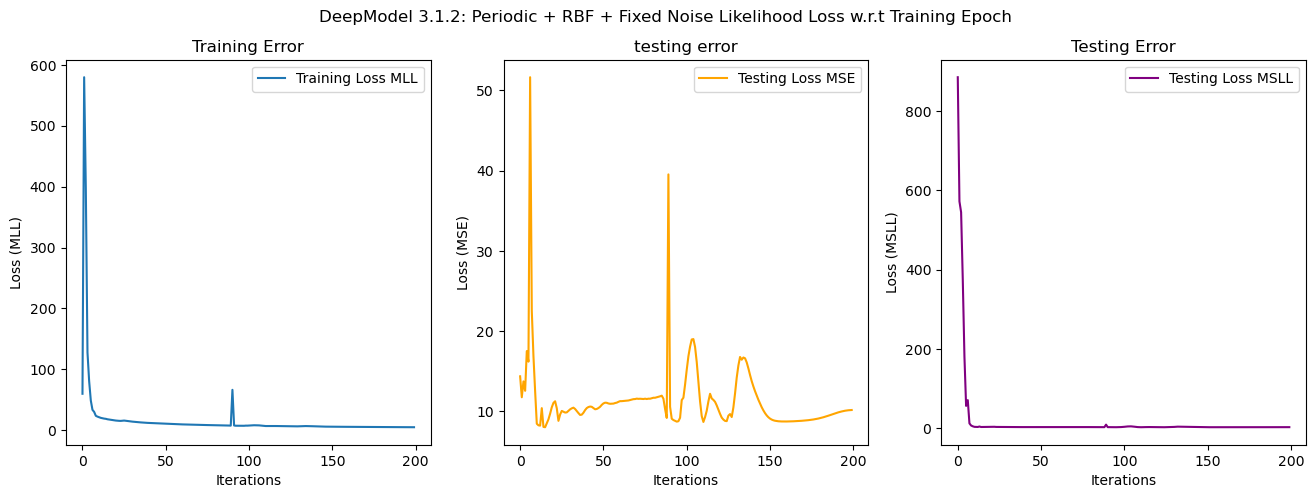

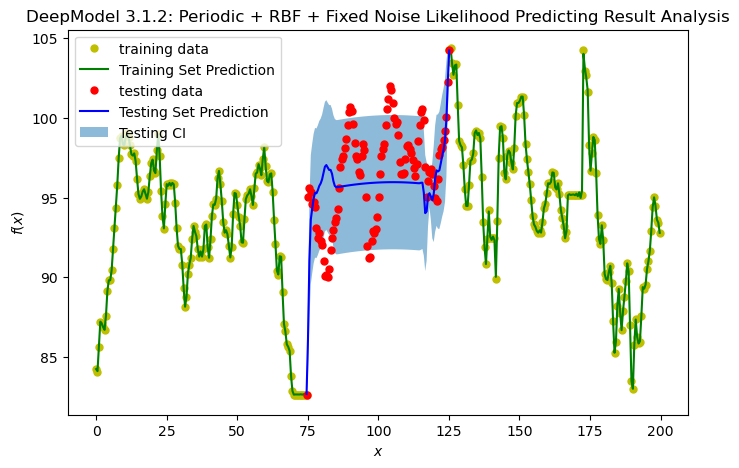

In [22]:
current_experiment_index = [2, 0, 1, 1]

#get our current model and likelihood
model, likelihood = Deep_GP_experiment(experiment_index = current_experiment_index)

#train the model & get loss log
train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  deep_training(model, likelihood, optimizer = torch.optim.Adam(model.parameters(), lr=0.1), mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model), training_iterations = 200)

#plot loss log
plot_loss_in_training_process_deep(current_experiment_index, train_losses_mll, test_losses_mse, test_losses_msll)

#plot training analysis
plot_predicting_result_deep(model, likelihood, current_experiment_index, X_train_deep, X_train_with_nan, Y_train_with_nan, X_test, Y_test)